In [2]:
%matplotlib inline
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

# Introduction

We have a dataset consisting of seal images and the respective labels for classification, courtesy of the University in Tromsø.

In [3]:
seal_data = sio.loadmat("seal_images.mat")

In [4]:
seal_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'img', 'y'])

In [5]:
seal_data["img"].shape

(1420, 128, 128, 3)

As we can see, we have a very small dataset, consisting of only 1420 sample images. 
This is way too small for training a CNN from scratch

In [6]:
np.unique(seal_data["y"], return_counts=True)

(array([-1,  1]), array([710, 710]))

In [11]:
np.where(seal_data["y"] == 1, seal_data["y"], 0)

array([[0],
       [1],
       [0],
       ...,
       [0],
       [1],
       [1]])

The dataset is balanced, we have equal number of samples from each class, which is good

We can take a look on some of the images with labels:

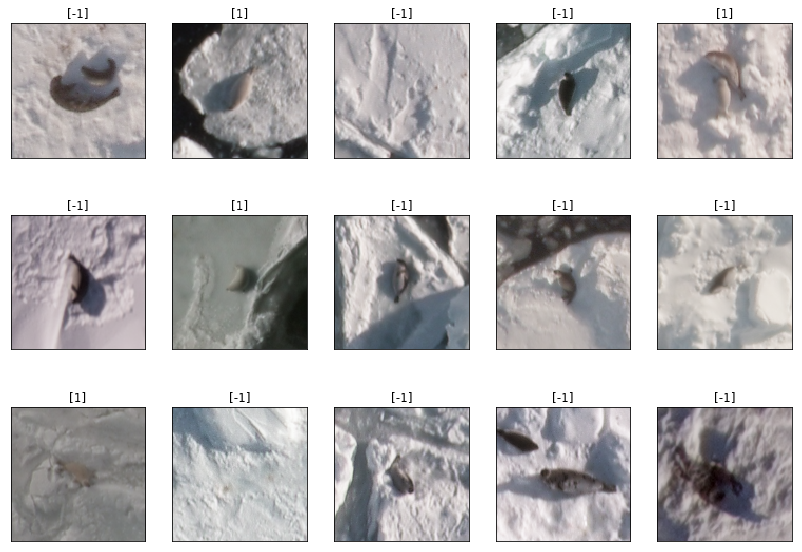

In [7]:
fig, axes = plt.subplots(ncols=5, nrows=3, figsize=(14,10))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(seal_data["img"][i])
    ax.set_title(seal_data["y"][i])
    ax.set_xticks([])
    ax.set_yticks([])

The seal images are of harp seal pups and hooded seal pups. We would want to classify these in order to get a more accurate population count.

The images are labeled by The Institute of Marine Research in Norway and the Nortwest Atlantic Fisheries Centre in Canada.

In order to get good classification performance on this small dataset,
we can try to utilize a concept in machine learning called **transfer learning**.

This means that we use the weights of a pre-trained network, often from a very complex architecture.

Then we can fine-tune the weights to our problem in hand.

**Our goals in this notebook are:**

1. Use transfer learning and fine-tuning such that we can get good classification performance on a small dataset
2. Write a 2-layer neural network from scratch in NumPy, in which we use the weights from the fine-tuned network to classify.

We could of course use the same network as in #1 to classify as well, but it is a nice exercise to write a neural network from scratch

*We are going to use the deep learning framework Keras with a TensorFlow-backend to fine-tune a network.*

# Transfer learning and fine tuning of a complex network

ImageNet from Google is a popular network to use

In [9]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

In [13]:
vgg16_model = keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 36s 0us/step


In [14]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [15]:
type(vgg16_model)

keras.engine.training.Model

In [16]:
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [18]:
model.layers.pop()

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [21]:
for layer in model.layers:
    layer.trainable = False

In [22]:
model.add(Dense(2, activation='softmax'))

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [24]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])